In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv("cleaned_final.csv")

In [5]:
pd.set_option('display.max_columns', None)
display(df.head())
df.shape

,PM10,SO2,CO,NO2,NOX,NO,O3,temp,feelslike,humidity,dew,windgust,windspeed,winddir,pressure,visibility,cloudcover,solarradiation,solarenergy,uvindex,hour,day,month,dayofweek,season,wind_dir_rad,wind_dir_sin,wind_dir_cos,weather_group_code,is_rainy,humidity_level,feelslike_diff,is_weekend,is_nighttime,is_rush_hour,humid_heat_index,uv_level
0,47.976,2.622,633.510,91.5125,123.564,44.600,4.0,10.0,10.0,87.38,8.0,16.6,9.4,250.0,1020.0,9.0,50.0,0.0,0.0,0.0,0,2,1,6,1,4.363323,-0.939693,-0.342020,0,0,2,0.0,1,1,0,873.80,0
1,50.498,2.786,537.026,90.1475,121.566,43.642,3.6,10.0,10.0,87.38,8.0,15.5,13.0,260.0,1021.0,10.0,50.0,0.0,0.0,0.0,1,2,1,6,1,4.537856,-0.984808,-0.173648,0,0,2,0.0,1,1,0,873.80,0
2,47.264,3.456,615.502,102.6875,119.832,39.820,3.4,10.0,10.0,87.38,8.0,15.8,13.0,260.0,1021.0,10.0,50.0,0.0,0.0,0.0,2,2,1,6,1,4.537856,-0.984808,-0.173648,0,0,2,0.0,1,1,0,873.80,0
3,46.026,3.260,693.612,82.3575,120.728,46.062,3.7,10.0,10.0,87.38,8.0,15.5,5.4,250.0,1021.0,10.0,50.0,0.0,0.0,0.0,3,2,1,6,1,4.363323,-0.939693,-0.342020,0,0,2,0.0,1,1,0,873.80,0
4,47.514,3.252,626.874,54.8325,97.116,41.600,4.0,9.0,9.0,93.45,8.0,14.4,0.0,0.0,1021.0,10.0,50.0,0.0,0.0,0.0,4,2,1,6,1,0.000000,0.000000,1.000000,0,0,2,0.0,1,1,0,841.05,0


(23782, 37)

In [42]:
#--------------------------------------------------PM10--------------------------------------------------------

In [29]:
def evaluate_catboost_o3(df, target='O3'):
    from catboost import CatBoostRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error, mean_squared_error,
        median_absolute_error, mean_absolute_percentage_error,
        explained_variance_score, max_error, r2_score
    )
    import numpy as np
    import pickle
    import matplotlib.pyplot as plt

    selected_features = [
        'temp', 'humidity', 'dew', 'windgust',
        'windspeed', 'pressure', 'cloudcover', 'visibility',
        'solarradiation', 'weather_group_code',

        'hour', 'day', 'month', 'dayofweek', 'season',
        'wind_dir_rad', 'wind_dir_sin', 'wind_dir_cos',
        'is_weekend', 'is_nighttime', 'is_rush_hour'
    ]

    X = df[selected_features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.1,
        depth=10,
        l2_leaf_reg=15,
        verbose=0,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metirkler
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    maxerr = max_error(y_test, y_test_pred)

    print(" CatBoost (Optimize) - O3 Tahmini:")
    print(f"Train MAE: {mae_train:.2f} | Test MAE: {mae_test:.2f}")
    print(f"Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f}")
    print(f"MAPE (Test): {mape*100:.2f}%")
    print(f"Median AE (Test): {medae:.2f}")
    print(f"Explained Variance Score: {evs:.4f}")
    print(f"Train R² Score: {r2_train:.4f} | Test R² Score: {r2:.4f}")
    print(f"Max Error: {maxerr:.2f}")

   # Plot 1: Actual vs Predicted
    plt.figure(figsize=(8, 5))
    plt.plot(y_test.values[:100], label="Actual", linewidth=2)
    plt.plot(y_test_pred[:100], label="Predicted", linewidth=2)
    plt.title("O3 - Actual vs Predicted")
    plt.xlabel("Index")
    plt.ylabel("O3 Concentration")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 3: Residual Plot
    residuals = y_test_pred - y_test
    plt.figure(figsize=(5, 2))
    plt.scatter(y_test, residuals, alpha=0.6, color='orange', edgecolor='k')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Actual O3 Value")
    plt.ylabel("Prediction Residual (Error)")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 4: Prediction Error Plot
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='teal', edgecolor='k', label="Predictions")
    plt.plot([0, 100], [0, 100], 'r--', label='y = x')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.xlabel("Actual O3 Value")
    plt.ylabel("Predicted O3 Value")
    plt.title("Prediction Error Plot")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    


 CatBoost (Optimize) - O3 Tahmini:
Train MAE: 3.93 | Test MAE: 6.91
Train RMSE: 5.28 | Test RMSE: 9.34
MAPE (Test): 119273356344205520.00%
Median AE (Test): 5.22
Explained Variance Score: 0.8519
Train R² Score: 0.9512 | Test R² Score: 0.8518
Max Error: 56.07


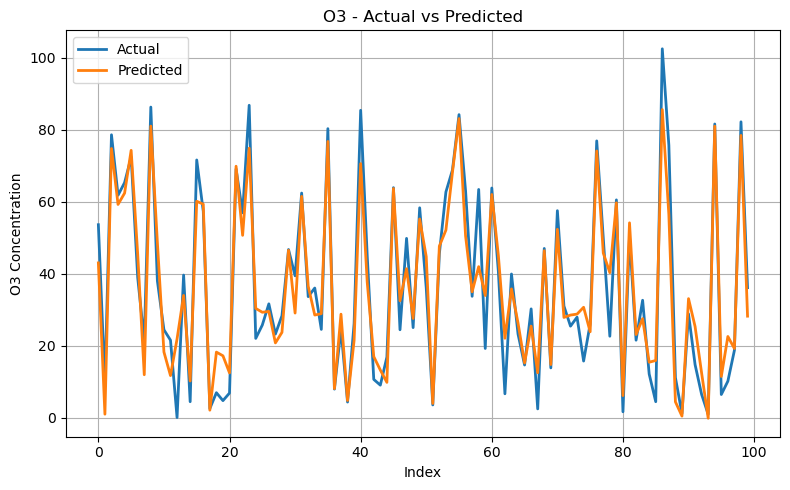

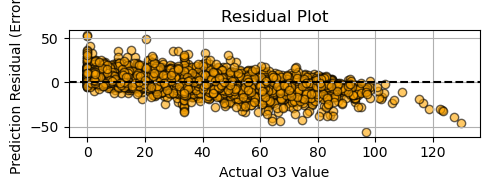

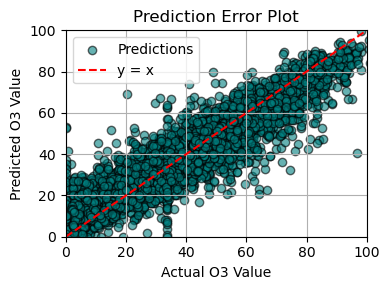

In [30]:
evaluate_catboost_o3(df)

In [45]:
#--------------------------------------------------SO2--------------------------------------------------------

In [ ]:
def evaluate_catboost_so2(df, target='SO2'):
    from catboost import CatBoostRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error, mean_squared_error,
        median_absolute_error, mean_absolute_percentage_error,
        explained_variance_score, max_error, r2_score
    )
    import numpy as np
    import pickle
    import matplotlib.pyplot as plt
    from sklearn.model_selection import learning_curve


    selected_features = [
        'temp', 'feelslike', 'humidity', 'dew', 'windgust',
        'windspeed', 'pressure', 'cloudcover', 'visibility',
        'solarradiation', 'uvindex', 'weather_group_code',
        'hour', 'day', 'month', 'dayofweek', 'season',
        'wind_dir_rad', 'wind_dir_sin', 'wind_dir_cos',
        'humidity_level', 'feelslike_diff', 'is_rainy',
        'is_weekend', 'is_nighttime', 'is_rush_hour',
        'humid_heat_index', 'uv_level'
    ]

    X = df[selected_features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = CatBoostRegressor(
        iterations=700,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=10,
        verbose=0,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metirkler
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    maxerr = max_error(y_test, y_test_pred)

    print(" CatBoost (Optimize) - SO2 Tahmini:")
    print(f"Train MAE: {mae_train:.2f} | Test MAE: {mae_test:.2f}")
    print(f"Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f}")
    print(f"MAPE (Test): {mape*100:.2f}%")
    print(f"Median AE (Test): {medae:.2f}")
    print(f"Explained Variance Score: {evs:.4f}")
    print(f"Train R² Score: {r2_train:.4f} | Test R² Score: {r2:.4f}")
    print(f"Max Error: {maxerr:.2f}")

    #  Grafik 1: Gerçek vs Tahmin (ilk 50 örnek)
    plt.figure(figsize=(8, 5))
    plt.plot(y_test.values[:50], label="Gerçek", linewidth=2)
    plt.plot(y_test_pred[:50], label="Tahmin", linewidth=2)
    plt.title("SO2 Tahmini - Gerçek vs Tahmin")
    plt.xlabel("Örnek")
    plt.ylabel("SO2 Değeri")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 2: Learning Curve (MAE & RMSE)
    train_sizes = np.linspace(0.1, 1.0, 6)
    _, train_scores_mae, test_scores_mae = learning_curve(
        model, X, y, train_sizes=train_sizes, scoring='neg_mean_absolute_error',
        cv=3, n_jobs=-1, shuffle=True, random_state=42
    )
    _, train_scores_rmse, test_scores_rmse = learning_curve(
        model, X, y, train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
        cv=3, n_jobs=-1, shuffle=True, random_state=42
    )

    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, -np.mean(train_scores_mae, axis=1), 'o-', label='Train MAE')
    plt.plot(train_sizes, -np.mean(test_scores_mae, axis=1), 'o-', label='Test MAE')
    plt.plot(train_sizes, -np.mean(train_scores_rmse, axis=1), 's--', label='Train RMSE')
    plt.plot(train_sizes, -np.mean(test_scores_rmse, axis=1), 's--', label='Test RMSE')
    plt.title("Learning Curve - MAE ve RMSE (CatBoost - SO2)")
    plt.xlabel("Eğitim Verisi Boyutu")
    plt.ylabel("Hata")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 1: Residual Plot (Artık Hata)
    residuals = y_test_pred - y_test
    plt.figure(figsize=(5, 2))
    plt.scatter(y_test, residuals, alpha=0.6, color='orange', edgecolor='k')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Gerçek SO2 Değeri")
    plt.ylabel("Tahmin Hatası (Residual)")
    plt.title("Residual Plot (Artık Hata Grafiği)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 2: Prediction Error Plot
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='teal', edgecolor='k', label="Tahminler")
    plt.plot([0, 15], [0, 15], 'r--', label='y = x')  
    plt.xlim(0, 15) 
    plt.ylim(0, 15) 
    plt.xlabel("Gerçek SO2 Değeri")
    plt.ylabel("Tahmin Edilen SO2")
    plt.title("Gerçek vs Tahmin - Prediction Error Plot")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    

📌 CatBoost (Optimize) - SO2 Tahmini:
Train MAE: 0.50 | Test MAE: 0.61
Train RMSE: 0.72 | Test RMSE: 0.90
MAPE (Test): 21.19%
Median AE (Test): 0.44
Explained Variance Score: 0.6056
Train R² Score: 0.7489 | Test R² Score: 0.6055
Max Error: 6.41


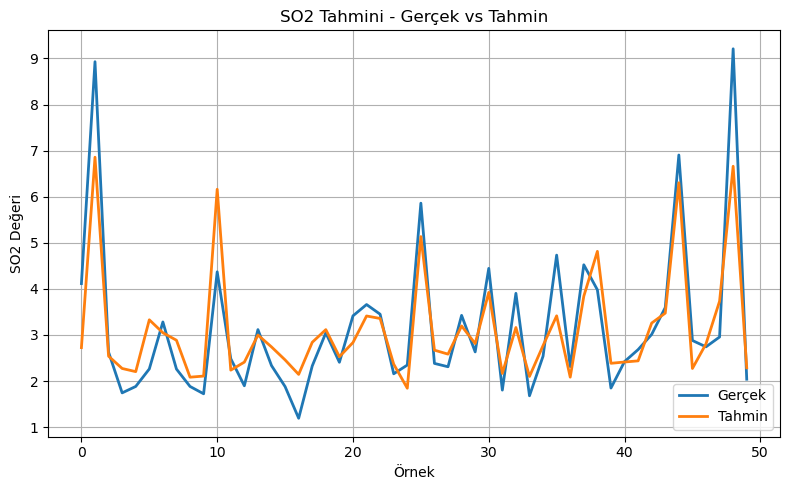

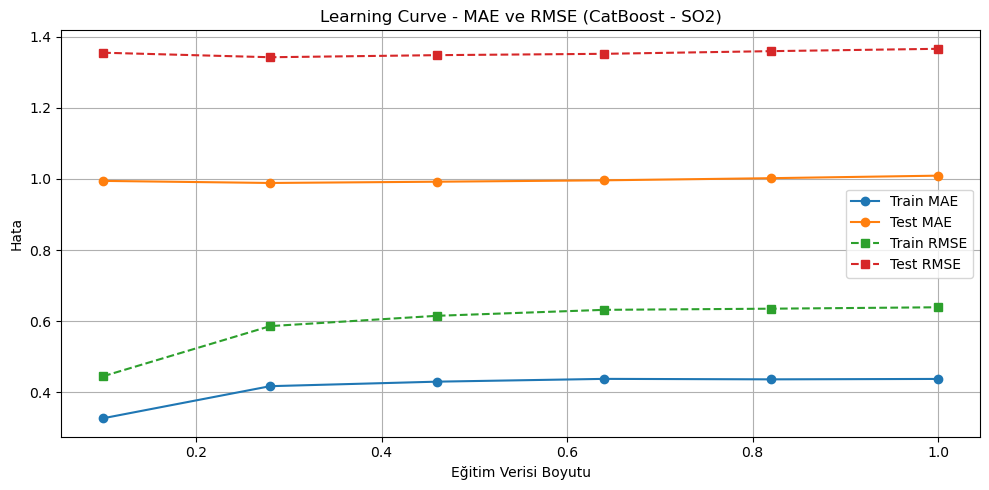

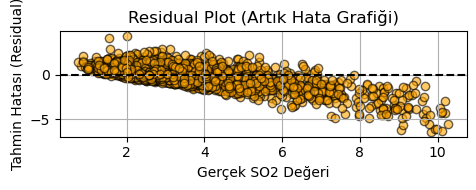

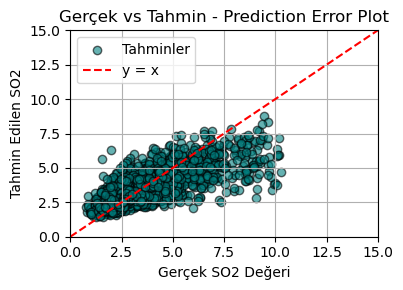

In [47]:
evaluate_catboost_so2(df)

In [48]:
#--------------------------------------------------CO--------------------------------------------------------

In [ ]:
def evaluate_catboost_co(df, target='CO'):
    from catboost import CatBoostRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error, mean_squared_error,
        median_absolute_error, mean_absolute_percentage_error,
        explained_variance_score, max_error, r2_score
    )
    import numpy as np
    import pickle
    import matplotlib.pyplot as plt
    from sklearn.model_selection import learning_curve


    selected_features = [
        'temp', 'feelslike', 'humidity', 'dew', 'windgust',
        'windspeed', 'pressure', 'cloudcover', 'visibility',
        'solarradiation', 'uvindex', 'weather_group_code',
        'hour', 'day', 'month', 'dayofweek', 'season',
        'wind_dir_rad', 'wind_dir_sin', 'wind_dir_cos',
        'humidity_level', 'feelslike_diff', 'is_rainy',
        'is_weekend', 'is_nighttime', 'is_rush_hour',
        'humid_heat_index', 'uv_level'
    ]

    X = df[selected_features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = CatBoostRegressor(
        iterations=700,
        learning_rate=0.05,
        depth=10,
        l2_leaf_reg=10,
        verbose=0,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metirkler
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    maxerr = max_error(y_test, y_test_pred)

    print(" CatBoost (Optimize) - CO Tahmini:")
    print(f"Train MAE: {mae_train:.2f} | Test MAE: {mae_test:.2f}")
    print(f"Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f}")
    print(f"MAPE (Test): {mape*100:.2f}%")
    print(f"Median AE (Test): {medae:.2f}")
    print(f"Explained Variance Score: {evs:.4f}")
    print(f"Train R² Score: {r2_train:.4f} | Test R² Score: {r2:.4f}")
    print(f"Max Error: {maxerr:.2f}")

    # #  Grafik 1: Gerçek vs Tahmin (ilk 50 örnek)
    # plt.figure(figsize=(8, 5))
    # plt.plot(y_test.values[:50], label="Gerçek", linewidth=2)
    # plt.plot(y_test_pred[:50], label="Tahmin", linewidth=2)
    # plt.title("CO Tahmini - Gerçek vs Tahmin")
    # plt.xlabel("Örnek")
    # plt.ylabel("CO Değeri")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    # #  Grafik 2: Learning Curve (MAE & RMSE)
    # train_sizes = np.linspace(0.1, 1.0, 6)
    # _, train_scores_mae, test_scores_mae = learning_curve(
    #     model, X, y, train_sizes=train_sizes, scoring='neg_mean_absolute_error',
    #     cv=3, n_jobs=-1, shuffle=True, random_state=42
    # )
    # _, train_scores_rmse, test_scores_rmse = learning_curve(
    #     model, X, y, train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
    #     cv=3, n_jobs=-1, shuffle=True, random_state=42
    # )

    # plt.figure(figsize=(10, 5))
    # plt.plot(train_sizes, -np.mean(train_scores_mae, axis=1), 'o-', label='Train MAE')
    # plt.plot(train_sizes, -np.mean(test_scores_mae, axis=1), 'o-', label='Test MAE')
    # plt.plot(train_sizes, -np.mean(train_scores_rmse, axis=1), 's--', label='Train RMSE')
    # plt.plot(train_sizes, -np.mean(test_scores_rmse, axis=1), 's--', label='Test RMSE')
    # plt.title("Learning Curve - MAE ve RMSE (CatBoost - CO)")
    # plt.xlabel("Eğitim Verisi Boyutu")
    # plt.ylabel("Hata")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    # #  Grafik 1: Residual Plot (Artık Hata)
    # residuals = y_test_pred - y_test
    # plt.figure(figsize=(5, 2))
    # plt.scatter(y_test, residuals, alpha=0.6, color='orange', edgecolor='k')
    # plt.axhline(0, color='black', linestyle='--')
    # plt.xlabel("Gerçek CO Değeri")
    # plt.ylabel("Tahmin Hatası (Residual)")
    # plt.title("Residual Plot (Artık Hata Grafiği)")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    #  Grafik 2: Prediction Error Plot
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='teal', edgecolor='k', label="Tahminler")
    plt.plot([0, 2000], [0, 2000], 'r--', label='y = x')  
    plt.xlim(0, 2000)  
    plt.ylim(0, 2000)  
    plt.xlabel("Gerçek CO Değeri")
    plt.ylabel("Tahmin Edilen CO")
    plt.title("Gerçek vs Tahmin - Prediction Error Plot")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

📌 CatBoost (Optimize) - CO Tahmini:
Train MAE: 51.07 | Test MAE: 66.71
Train RMSE: 67.77 | Test RMSE: 89.32
MAPE (Test): 16.61%
Median AE (Test): 51.66
Explained Variance Score: 0.6692
Train R² Score: 0.8157 | Test R² Score: 0.6692
Max Error: 596.31


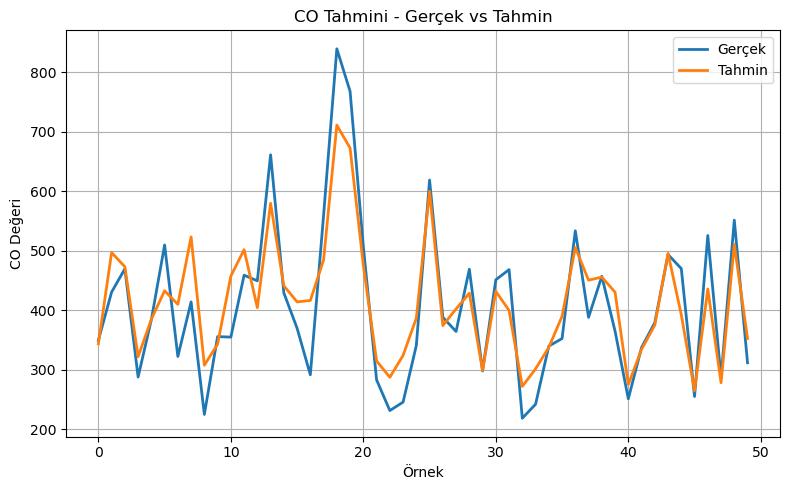

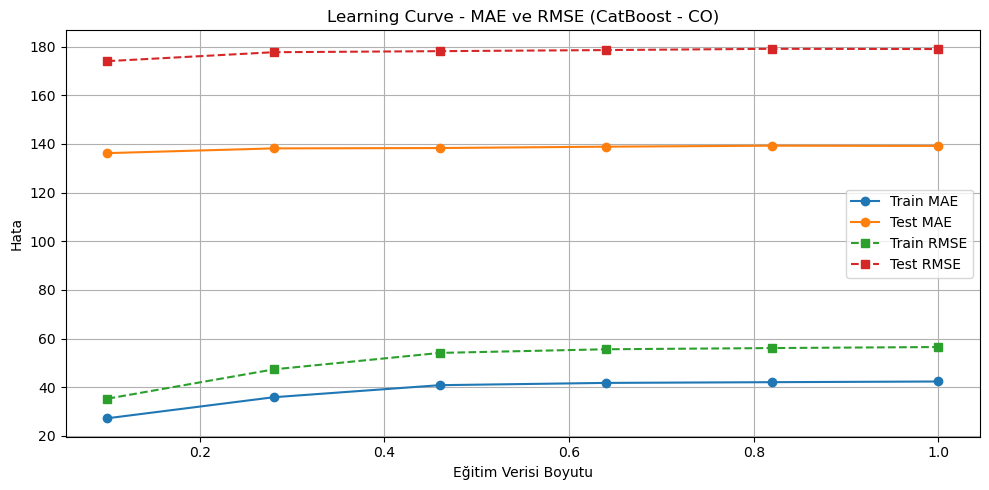

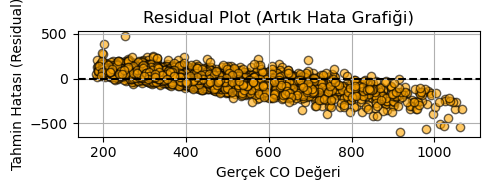

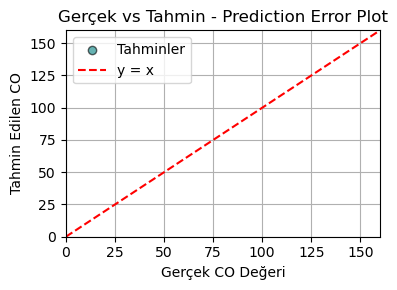

In [50]:
evaluate_catboost_co(df)

In [ ]:
def evaluate_catboost_co2(df, target='CO'):
    from catboost import CatBoostRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error, mean_squared_error,
        median_absolute_error, mean_absolute_percentage_error,
        explained_variance_score, max_error, r2_score
    )
    import numpy as np
    import pickle
    import matplotlib.pyplot as plt
    from sklearn.model_selection import learning_curve


    selected_features = [
        'temp', 'feelslike', 'humidity', 'dew', 'windgust',
        'windspeed', 'pressure', 'cloudcover', 'visibility',
        'solarradiation', 'uvindex', 'weather_group_code',
        'hour', 'day', 'month', 'dayofweek', 'season',
        'wind_dir_rad', 'wind_dir_sin', 'wind_dir_cos',
        'humidity_level', 'feelslike_diff', 'is_rainy',
        'is_weekend', 'is_nighttime', 'is_rush_hour',
        'humid_heat_index', 'uv_level'
    ]

    X = df[selected_features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = CatBoostRegressor(
        iterations=700,
        learning_rate=0.05,
        depth=10,
        l2_leaf_reg=10,
        verbose=0,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metirkler
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    maxerr = max_error(y_test, y_test_pred)

    print(" CatBoost (Optimize) - CO Tahmini:")
    print(f"Train MAE: {mae_train:.2f} | Test MAE: {mae_test:.2f}")
    print(f"Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f}")
    print(f"MAPE (Test): {mape*100:.2f}%")
    print(f"Median AE (Test): {medae:.2f}")
    print(f"Explained Variance Score: {evs:.4f}")
    print(f"Train R² Score: {r2_train:.4f} | Test R² Score: {r2:.4f}")
    print(f"Max Error: {maxerr:.2f}")

    # #  Grafik 1: Gerçek vs Tahmin (ilk 50 örnek)
    # plt.figure(figsize=(8, 5))
    # plt.plot(y_test.values[:50], label="Gerçek", linewidth=2)
    # plt.plot(y_test_pred[:50], label="Tahmin", linewidth=2)
    # plt.title("CO Tahmini - Gerçek vs Tahmin")
    # plt.xlabel("Örnek")
    # plt.ylabel("CO Değeri")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    # #  Grafik 2: Learning Curve (MAE & RMSE)
    # train_sizes = np.linspace(0.1, 1.0, 6)
    # _, train_scores_mae, test_scores_mae = learning_curve(
    #     model, X, y, train_sizes=train_sizes, scoring='neg_mean_absolute_error',
    #     cv=3, n_jobs=-1, shuffle=True, random_state=42
    # )
    # _, train_scores_rmse, test_scores_rmse = learning_curve(
    #     model, X, y, train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
    #     cv=3, n_jobs=-1, shuffle=True, random_state=42
    # )

    # plt.figure(figsize=(10, 5))
    # plt.plot(train_sizes, -np.mean(train_scores_mae, axis=1), 'o-', label='Train MAE')
    # plt.plot(train_sizes, -np.mean(test_scores_mae, axis=1), 'o-', label='Test MAE')
    # plt.plot(train_sizes, -np.mean(train_scores_rmse, axis=1), 's--', label='Train RMSE')
    # plt.plot(train_sizes, -np.mean(test_scores_rmse, axis=1), 's--', label='Test RMSE')
    # plt.title("Learning Curve - MAE ve RMSE (CatBoost - CO)")
    # plt.xlabel("Eğitim Verisi Boyutu")
    # plt.ylabel("Hata")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    # #  Grafik 1: Residual Plot (Artık Hata)
    # residuals = y_test_pred - y_test
    # plt.figure(figsize=(5, 2))
    # plt.scatter(y_test, residuals, alpha=0.6, color='orange', edgecolor='k')
    # plt.axhline(0, color='black', linestyle='--')
    # plt.xlabel("Gerçek CO Değeri")
    # plt.ylabel("Tahmin Hatası (Residual)")
    # plt.title("Residual Plot (Artık Hata Grafiği)")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    #  Grafik 2: Prediction Error Plot
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='teal', edgecolor='k', label="Tahminler")
    plt.plot([0, 1500], [0, 1500], 'r--', label='y = x')  
    plt.xlim(0, 1500)  
    plt.ylim(0, 1500)  
    plt.xlabel("Gerçek CO Değeri")
    plt.ylabel("Tahmin Edilen CO")
    plt.title("Gerçek vs Tahmin - Prediction Error Plot")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

📌 CatBoost (Optimize) - CO Tahmini:
Train MAE: 51.07 | Test MAE: 66.71
Train RMSE: 67.77 | Test RMSE: 89.32
MAPE (Test): 16.61%
Median AE (Test): 51.66
Explained Variance Score: 0.6692
Train R² Score: 0.8157 | Test R² Score: 0.6692
Max Error: 596.31


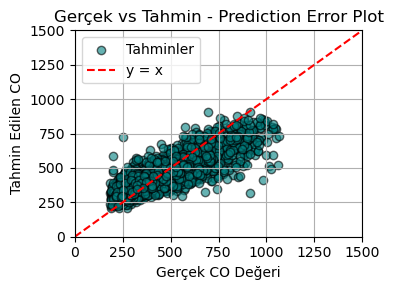

In [63]:
evaluate_catboost_co2(df)

In [51]:
#--------------------------------------------------NO--------------------------------------------------------

In [ ]:
def evaluate_catboost_no(df, target='NO'):
    from catboost import CatBoostRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error, mean_squared_error,
        median_absolute_error, mean_absolute_percentage_error,
        explained_variance_score, max_error, r2_score
    )
    import numpy as np
    import pickle
    import matplotlib.pyplot as plt
    from sklearn.model_selection import learning_curve

    selected_features = [
        'temp', 'feelslike', 'humidity', 'dew', 'windgust',
        'windspeed', 'pressure', 'cloudcover', 'visibility',
        'solarradiation', 'uvindex', 'weather_group_code',
        'hour', 'day', 'month', 'dayofweek', 'season',
        'wind_dir_rad', 'wind_dir_sin', 'wind_dir_cos',
        'humidity_level', 'feelslike_diff', 'is_rainy',
        'is_weekend', 'is_nighttime', 'is_rush_hour',
        'humid_heat_index', 'uv_level'
    ]

    X = df[selected_features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = CatBoostRegressor(
        iterations=600,
        learning_rate=0.075,
        depth=10,
        l2_leaf_reg=15,
        verbose=0,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metirkler
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    maxerr = max_error(y_test, y_test_pred)

    print(" CatBoost (Optimize) - NO Tahmini:")
    print(f"Train MAE: {mae_train:.2f} | Test MAE: {mae_test:.2f}")
    print(f"Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f}")
    print(f"MAPE (Test): {mape*100:.2f}%")
    print(f"Median AE (Test): {medae:.2f}")
    print(f"Explained Variance Score: {evs:.4f}")
    print(f"Train R² Score: {r2_train:.4f} | Test R² Score: {r2:.4f}")
    print(f"Max Error: {maxerr:.2f}")

    #  Grafik 1: Gerçek vs Tahmin 
    plt.figure(figsize=(8, 5))
    plt.plot(y_test.values[:50], label="Gerçek", linewidth=2)
    plt.plot(y_test_pred[:50], label="Tahmin", linewidth=2)
    plt.title("NO Tahmini - Gerçek vs Tahmin")
    plt.xlabel("Örnek")
    plt.ylabel("NO Değeri")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 2: Learning Curve (MAE & RMSE)
    train_sizes = np.linspace(0.1, 1.0, 6)
    _, train_scores_mae, test_scores_mae = learning_curve(
        model, X, y, train_sizes=train_sizes, scoring='neg_mean_absolute_error',
        cv=3, n_jobs=-1, shuffle=True, random_state=42
    )
    _, train_scores_rmse, test_scores_rmse = learning_curve(
        model, X, y, train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
        cv=3, n_jobs=-1, shuffle=True, random_state=42
    )

    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, -np.mean(train_scores_mae, axis=1), 'o-', label='Train MAE')
    plt.plot(train_sizes, -np.mean(test_scores_mae, axis=1), 'o-', label='Test MAE')
    plt.plot(train_sizes, -np.mean(train_scores_rmse, axis=1), 's--', label='Train RMSE')
    plt.plot(train_sizes, -np.mean(test_scores_rmse, axis=1), 's--', label='Test RMSE')
    plt.title("Learning Curve - MAE ve RMSE (CatBoost - NO)")
    plt.xlabel("Eğitim Verisi Boyutu")
    plt.ylabel("Hata")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 1: Residual Plot (Artık Hata)
    residuals = y_test_pred - y_test
    plt.figure(figsize=(5, 2))
    plt.scatter(y_test, residuals, alpha=0.6, color='orange', edgecolor='k')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Gerçek NO Değeri")
    plt.ylabel("Tahmin Hatası (Residual)")
    plt.title("Residual Plot (Artık Hata Grafiği)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 2: Prediction Error Plot
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='teal', edgecolor='k', label="Tahminler")
    plt.plot([0, 160], [0, 160], 'r--', label='y = x') 
    plt.xlim(0, 160)  
    plt.ylim(0, 160)  
    plt.xlabel("Gerçek NO Değeri")
    plt.ylabel("Tahmin Edilen NO")
    plt.title("Gerçek vs Tahmin - Prediction Error Plot")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

📌 CatBoost (Optimize) - NO Tahmini:
Train MAE: 3.30 | Test MAE: 4.65
Train RMSE: 4.34 | Test RMSE: 6.16
MAPE (Test): 16.91%
Median AE (Test): 3.60
Explained Variance Score: 0.7004
Train R² Score: 0.8503 | Test R² Score: 0.7003
Max Error: 36.49


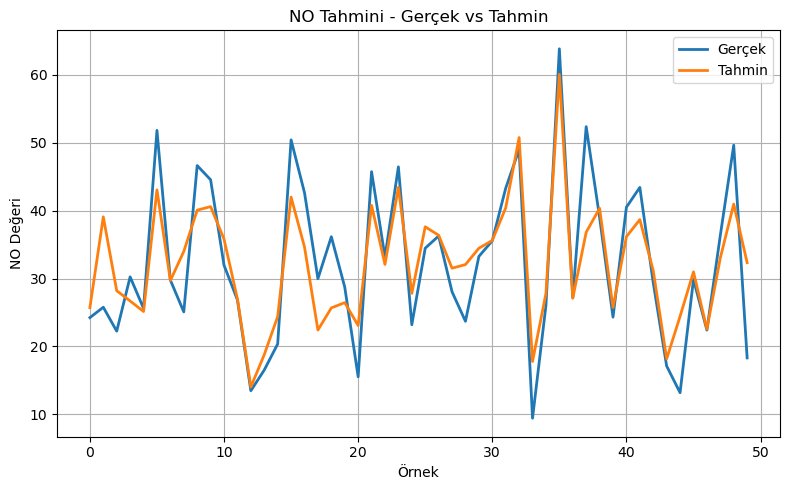

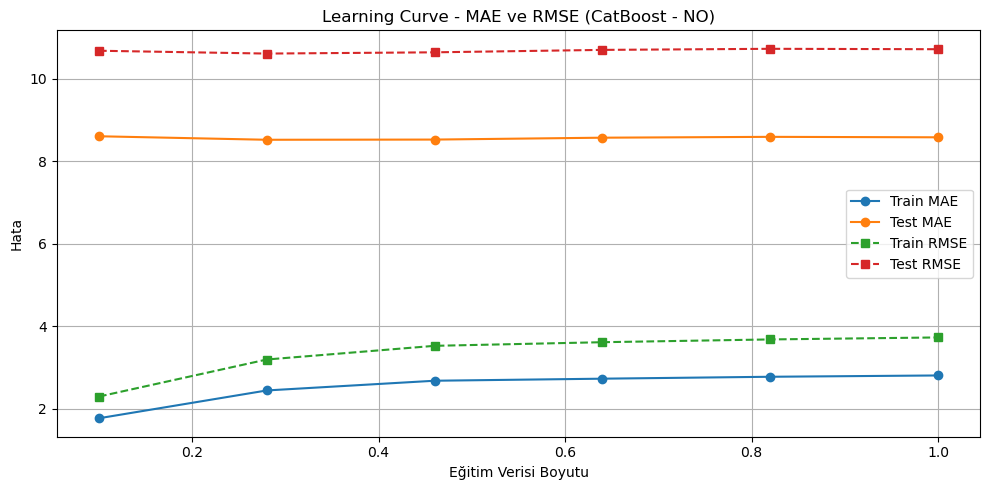

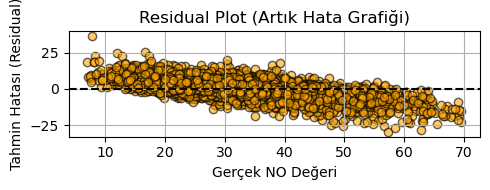

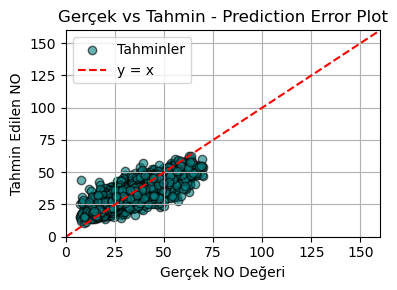

In [65]:
evaluate_catboost_no(df)

In [53]:
#--------------------------------------------------NO2--------------------------------------------------------

In [ ]:
def evaluate_catboost_no2(df, target='NO2'):
    from catboost import CatBoostRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error, mean_squared_error,
        median_absolute_error, mean_absolute_percentage_error,
        explained_variance_score, max_error, r2_score
    )
    import numpy as np
    import pickle
    import matplotlib.pyplot as plt
    from sklearn.model_selection import learning_curve

    selected_features = [
        'temp', 'feelslike', 'humidity', 'dew', 'windgust',
        'windspeed', 'pressure', 'cloudcover', 'visibility',
        'solarradiation', 'uvindex', 'weather_group_code',
        'hour', 'day', 'month', 'dayofweek', 'season',
        'wind_dir_rad', 'wind_dir_sin', 'wind_dir_cos',
        'humidity_level', 'feelslike_diff', 'is_rainy',
        'is_weekend', 'is_nighttime', 'is_rush_hour',
        'humid_heat_index', 'uv_level'
    ]

    X = df[selected_features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = CatBoostRegressor(
        iterations=700,
        learning_rate=0.15,
        depth=10,
        l2_leaf_reg=15,
        verbose=0,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metirkler
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    maxerr = max_error(y_test, y_test_pred)

    print(" CatBoost (Optimize) - NO2 Tahmini:")
    print(f"Train MAE: {mae_train:.2f} | Test MAE: {mae_test:.2f}")
    print(f"Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f}")
    print(f"MAPE (Test): {mape*100:.2f}%")
    print(f"Median AE (Test): {medae:.2f}")
    print(f"Explained Variance Score: {evs:.4f}")
    print(f"Train R² Score: {r2_train:.4f} | Test R² Score: {r2:.4f}")
    print(f"Max Error: {maxerr:.2f}")

    #  Grafik 1: Gerçek vs Tahmin 
    plt.figure(figsize=(8, 5))
    plt.plot(y_test.values[:50], label="Gerçek", linewidth=2)
    plt.plot(y_test_pred[:50], label="Tahmin", linewidth=2)
    plt.title("NO2 Tahmini - Gerçek vs Tahmin")
    plt.xlabel("Örnek")
    plt.ylabel("NO2 Değeri")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 2: Learning Curve (MAE & RMSE)
    train_sizes = np.linspace(0.1, 1.0, 6)
    _, train_scores_mae, test_scores_mae = learning_curve(
        model, X, y, train_sizes=train_sizes, scoring='neg_mean_absolute_error',
        cv=3, n_jobs=-1, shuffle=True, random_state=42
    )
    _, train_scores_rmse, test_scores_rmse = learning_curve(
        model, X, y, train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
        cv=3, n_jobs=-1, shuffle=True, random_state=42
    )

    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, -np.mean(train_scores_mae, axis=1), 'o-', label='Train MAE')
    plt.plot(train_sizes, -np.mean(test_scores_mae, axis=1), 'o-', label='Test MAE')
    plt.plot(train_sizes, -np.mean(train_scores_rmse, axis=1), 's--', label='Train RMSE')
    plt.plot(train_sizes, -np.mean(test_scores_rmse, axis=1), 's--', label='Test RMSE')
    plt.title("Learning Curve - MAE ve RMSE (CatBoost - NO2)")
    plt.xlabel("Eğitim Verisi Boyutu")
    plt.ylabel("Hata")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 1: Residual Plot (Artık Hata)
    residuals = y_test_pred - y_test
    plt.figure(figsize=(5, 2))
    plt.scatter(y_test, residuals, alpha=0.6, color='orange', edgecolor='k')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Gerçek NO2 Değeri")
    plt.ylabel("Tahmin Hatası (Residual)")
    plt.title("Residual Plot (Artık Hata Grafiği)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 2: Prediction Error Plot
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='teal', edgecolor='k', label="Tahminler")
    plt.plot([0, 160], [0, 160], 'r--', label='y = x')  
    plt.xlim(0, 160)  
    plt.ylim(0, 160)  
    plt.xlabel("Gerçek NO2 Değeri")
    plt.ylabel("Tahmin Edilen NO2")
    plt.title("Gerçek vs Tahmin - Prediction Error Plot")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

📌 CatBoost (Optimize) - NO2 Tahmini:
Train MAE: 3.97 | Test MAE: 7.84
Train RMSE: 5.38 | Test RMSE: 11.24
MAPE (Test): 17.09%
Median AE (Test): 5.48
Explained Variance Score: 0.8141
Train R² Score: 0.9576 | Test R² Score: 0.8141
Max Error: 77.49


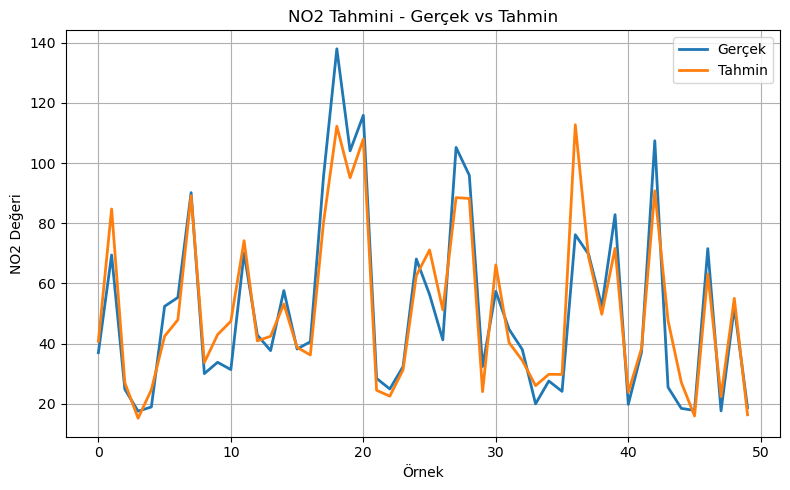

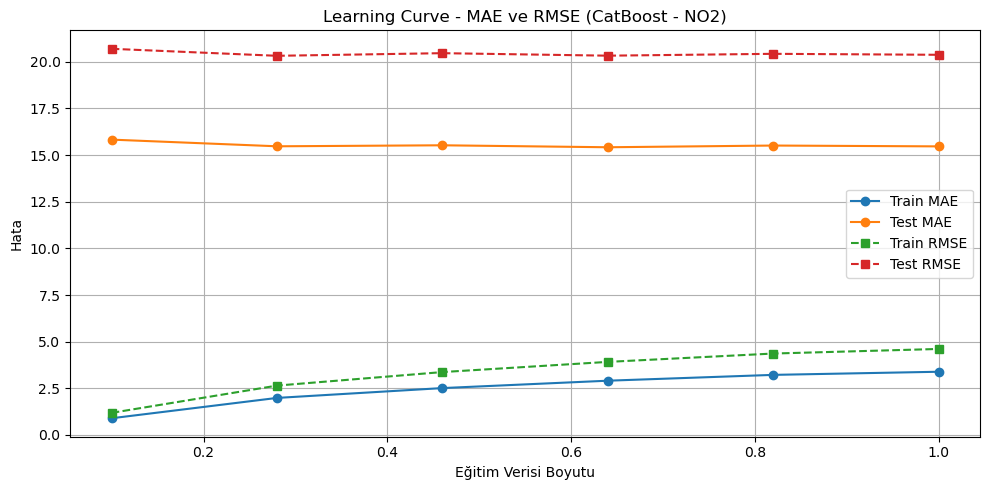

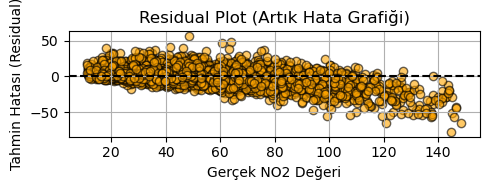

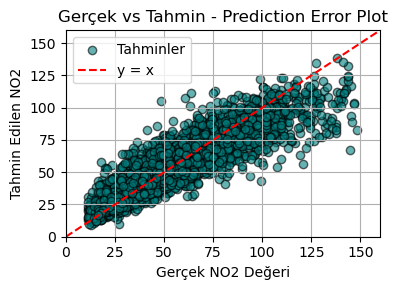

In [67]:
evaluate_catboost_no2(df)

In [55]:
#--------------------------------------------------NOX--------------------------------------------------------

In [ ]:
def evaluate_catboost_nox(df, target='NOX'):
    from catboost import CatBoostRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error, mean_squared_error,
        median_absolute_error, mean_absolute_percentage_error,
        explained_variance_score, max_error, r2_score
    )
    import numpy as np
    import pickle
    import matplotlib.pyplot as plt
    from sklearn.model_selection import learning_curve

    selected_features = [
        'temp', 'feelslike', 'humidity', 'dew', 'windgust',
        'windspeed', 'pressure', 'cloudcover', 'visibility',
        'solarradiation', 'uvindex', 'weather_group_code',
        'hour', 'day', 'month', 'dayofweek', 'season',
        'wind_dir_rad', 'wind_dir_sin', 'wind_dir_cos',
        'humidity_level', 'feelslike_diff', 'is_rainy',
        'is_weekend', 'is_nighttime', 'is_rush_hour',
        'humid_heat_index', 'uv_level'
    ]

    X = df[selected_features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = CatBoostRegressor(
        iterations=600,
        learning_rate=0.08,
        depth=10,
        l2_leaf_reg=15,
        verbose=0,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metirkler
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    maxerr = max_error(y_test, y_test_pred)

    print(" CatBoost (Optimize) - NOX Tahmini:")
    print(f"Train MAE: {mae_train:.2f} | Test MAE: {mae_test:.2f}")
    print(f"Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f}")
    print(f"MAPE (Test): {mape*100:.2f}%")
    print(f"Median AE (Test): {medae:.2f}")
    print(f"Explained Variance Score: {evs:.4f}")
    print(f"Train R² Score: {r2_train:.4f} | Test R² Score: {r2:.4f}")
    print(f"Max Error: {maxerr:.2f}")

    #  Grafik 1: Gerçek vs Tahmin 
    plt.figure(figsize=(8, 5))
    plt.plot(y_test.values[:50], label="Gerçek", linewidth=2)
    plt.plot(y_test_pred[:50], label="Tahmin", linewidth=2)
    plt.title("NOX Tahmini - Gerçek vs Tahmin")
    plt.xlabel("Örnek")
    plt.ylabel("NOX Değeri")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 2: Learning Curve (MAE & RMSE)
    train_sizes = np.linspace(0.1, 1.0, 6)
    _, train_scores_mae, test_scores_mae = learning_curve(
        model, X, y, train_sizes=train_sizes, scoring='neg_mean_absolute_error',
        cv=3, n_jobs=-1, shuffle=True, random_state=42
    )
    _, train_scores_rmse, test_scores_rmse = learning_curve(
        model, X, y, train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
        cv=3, n_jobs=-1, shuffle=True, random_state=42
    )

    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, -np.mean(train_scores_mae, axis=1), 'o-', label='Train MAE')
    plt.plot(train_sizes, -np.mean(test_scores_mae, axis=1), 'o-', label='Test MAE')
    plt.plot(train_sizes, -np.mean(train_scores_rmse, axis=1), 's--', label='Train RMSE')
    plt.plot(train_sizes, -np.mean(test_scores_rmse, axis=1), 's--', label='Test RMSE')
    plt.title("Learning Curve - MAE ve RMSE (CatBoost - NOX)")
    plt.xlabel("Eğitim Verisi Boyutu")
    plt.ylabel("Hata")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 1: Residual Plot (Artık Hata)
    residuals = y_test_pred - y_test
    plt.figure(figsize=(5, 2))
    plt.scatter(y_test, residuals, alpha=0.6, color='orange', edgecolor='k')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Gerçek NOX Değeri")
    plt.ylabel("Tahmin Hatası (Residual)")
    plt.title("Residual Plot (Artık Hata Grafiği)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 2: Prediction Error Plot
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='teal', edgecolor='k', label="Tahminler")
    plt.plot([0, 160], [0, 160], 'r--', label='y = x')  
    plt.xlim(0, 160)  
    plt.ylim(0, 160)  
    plt.xlabel("Gerçek NOX Değeri")
    plt.ylabel("Tahmin Edilen NOX")
    plt.title("Gerçek vs Tahmin - Prediction Error Plot")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

📌 CatBoost (Optimize) - NOX Tahmini:
Train MAE: 5.88 | Test MAE: 8.67
Train RMSE: 8.14 | Test RMSE: 12.58
MAPE (Test): 20.02%
Median AE (Test): 5.91
Explained Variance Score: 0.7699
Train R² Score: 0.9087 | Test R² Score: 0.7699
Max Error: 82.20


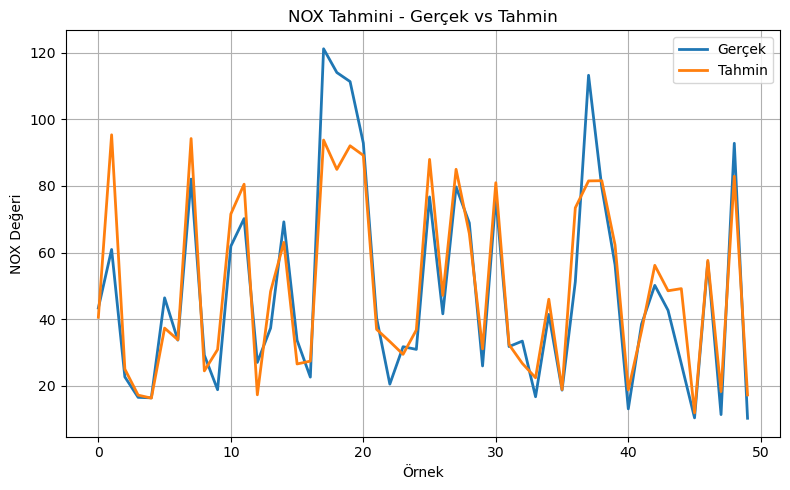

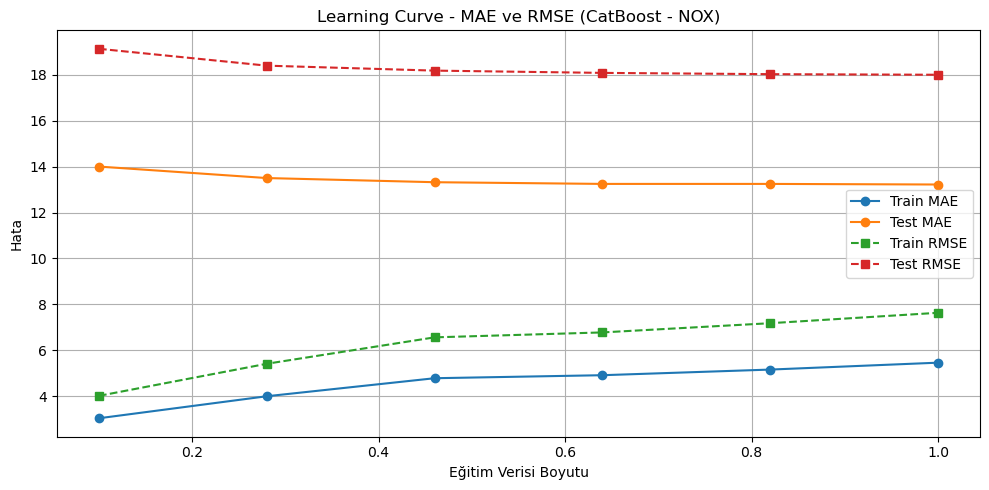

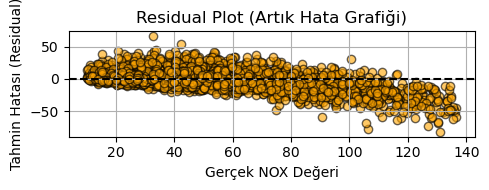

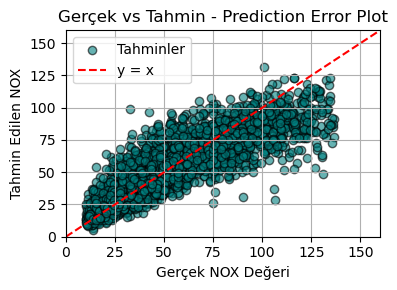

In [69]:
evaluate_catboost_nox(df)

In [57]:
#--------------------------------------------------O3--------------------------------------------------------

In [ ]:
def evaluate_catboost_o3(df, target='O3'):
    from catboost import CatBoostRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error, mean_squared_error,
        median_absolute_error, mean_absolute_percentage_error,
        explained_variance_score, max_error, r2_score
    )
    import numpy as np
    import pickle
    import matplotlib.pyplot as plt
    from sklearn.model_selection import learning_curve

    selected_features = [
        'temp', 'feelslike', 'humidity', 'dew', 'windgust',
        'windspeed', 'pressure', 'cloudcover', 'visibility',
        'solarradiation', 'uvindex', 'weather_group_code',
        'hour', 'day', 'month', 'dayofweek', 'season',
        'wind_dir_rad', 'wind_dir_sin', 'wind_dir_cos',
        'humidity_level', 'feelslike_diff', 'is_rainy',
        'is_weekend', 'is_nighttime', 'is_rush_hour',
        'humid_heat_index', 'uv_level'
    ]

    X = df[selected_features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.1,
        depth=10,
        l2_leaf_reg=15,
        verbose=0,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metirkler
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    maxerr = max_error(y_test, y_test_pred)

    print(" CatBoost (Optimize) - O3 Tahmini:")
    print(f"Train MAE: {mae_train:.2f} | Test MAE: {mae_test:.2f}")
    print(f"Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f}")
    print(f"MAPE (Test): {mape*100:.2f}%")
    print(f"Median AE (Test): {medae:.2f}")
    print(f"Explained Variance Score: {evs:.4f}")
    print(f"Train R² Score: {r2_train:.4f} | Test R² Score: {r2:.4f}")
    print(f"Max Error: {maxerr:.2f}")

    #  Grafik 1: Gerçek vs Tahmin 
    plt.figure(figsize=(8, 5))
    plt.plot(y_test.values[:50], label="Gerçek", linewidth=2)
    plt.plot(y_test_pred[:50], label="Tahmin", linewidth=2)
    plt.title("O3 Tahmini - Gerçek vs Tahmin")
    plt.xlabel("Örnek")
    plt.ylabel("O3 Değeri")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 2: Learning Curve (MAE & RMSE)
    train_sizes = np.linspace(0.1, 1.0, 6)
    _, train_scores_mae, test_scores_mae = learning_curve(
        model, X, y, train_sizes=train_sizes, scoring='neg_mean_absolute_error',
        cv=3, n_jobs=-1, shuffle=True, random_state=42
    )
    _, train_scores_rmse, test_scores_rmse = learning_curve(
        model, X, y, train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
        cv=3, n_jobs=-1, shuffle=True, random_state=42
    )

    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, -np.mean(train_scores_mae, axis=1), 'o-', label='Train MAE')
    plt.plot(train_sizes, -np.mean(test_scores_mae, axis=1), 'o-', label='Test MAE')
    plt.plot(train_sizes, -np.mean(train_scores_rmse, axis=1), 's--', label='Train RMSE')
    plt.plot(train_sizes, -np.mean(test_scores_rmse, axis=1), 's--', label='Test RMSE')
    plt.title("Learning Curve - MAE ve RMSE (CatBoost - O3)")
    plt.xlabel("Eğitim Verisi Boyutu")
    plt.ylabel("Hata")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Grafik 1: Residual Plot (Artık Hata)
    residuals = y_test_pred - y_test
    plt.figure(figsize=(5, 2))
    plt.scatter(y_test, residuals, alpha=0.6, color='orange', edgecolor='k')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Gerçek O3 Değeri")
    plt.ylabel("Tahmin Hatası (Residual)")
    plt.title("Residual Plot (Artık Hata Grafiği)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Grafik 2: Prediction Error Plot
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='teal', edgecolor='k', label="Tahminler")
    plt.plot([0, 160], [0, 160], 'r--', label='y = x')  
    plt.xlim(0, 160)  
    plt.ylim(0, 160)  
    plt.xlabel("Gerçek O3 Değeri")
    plt.ylabel("Tahmin Edilen O3")
    plt.title("Gerçek vs Tahmin - Prediction Error Plot")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

📌 CatBoost (Optimize) - O3 Tahmini:
Train MAE: 3.88 | Test MAE: 6.87
Train RMSE: 5.22 | Test RMSE: 9.28
MAPE (Test): 126019837673356192.00%
Median AE (Test): 5.25
Explained Variance Score: 0.8537
Train R² Score: 0.9523 | Test R² Score: 0.8536
Max Error: 53.63


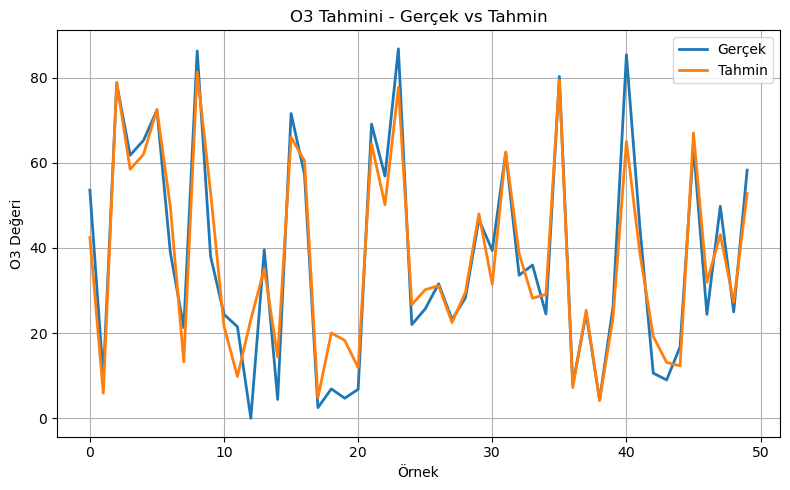

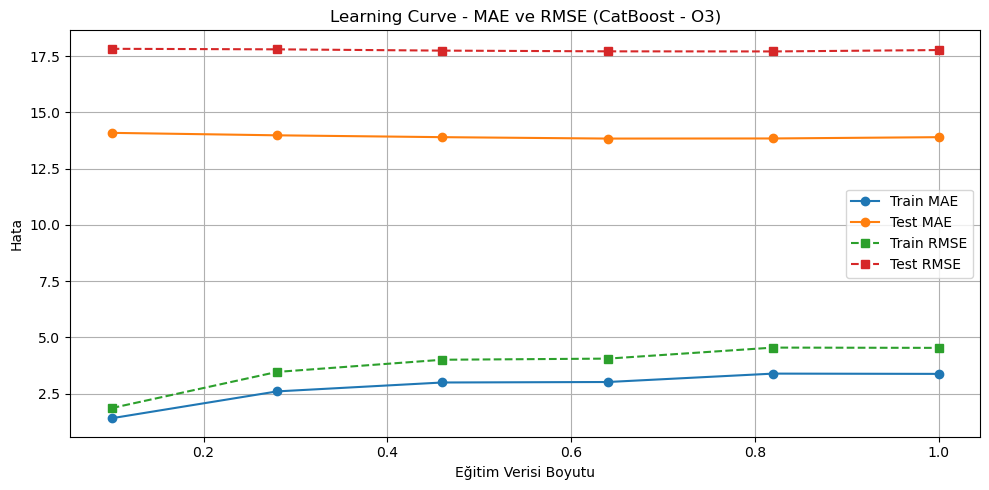

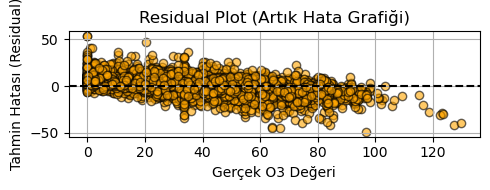

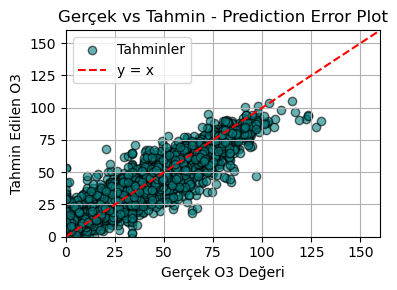

In [71]:
evaluate_catboost_o3(df)